Camera calibration using chessboard images

True

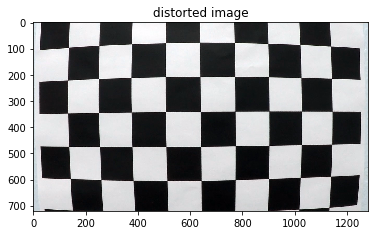

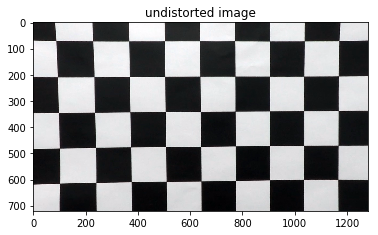

In [117]:
counter = 0
gen_images = False

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)     

# read and undistort a test image
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure()
plt.title('distorted image')
plt.imshow(img)
cv2.imwrite('test_images/distorted.jpg', img)


plt.figure()
plt.title('undistorted image')
plt.imshow(dst)
cv2.imwrite('test_images/undistorted.jpg', dst)


In [112]:
def warp_image(img):
    global counter
    global gen_images
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    if gen_images:
        im = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)                
        cv2.imwrite('./images/' + 'before_wrap' + str(counter) + '.png', im)
        im = cv2.cvtColor(warped.astype(np.uint8), cv2.COLOR_RGB2BGR)        
        cv2.imwrite('./images/' + 'wraped' + str(counter) + '.png', im)
    
    return warped

def unwarp_image(img):
    global counter
    global gen_images
    
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    if gen_images:
        im = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)        
        
        cv2.imwrite('./images/' + 'before_unwrap' + str(counter) + '.png', im)
        im = cv2.cvtColor(unwarped.astype(np.uint8), cv2.COLOR_RGB2BGR)        
        
        cv2.imwrite('./images/' + 'unwraped' + str(counter) + '.png', im)

    return unwarped

## Build a Lane Finding Pipeline


Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [103]:
def color_and_gradient_pipeline(img, s_thresh=(200, 255), thresh = (0.7, 1.3), sx_thresh=(10, 255), sy_thresh=(10, 255)):
    
    #apply gussian blurring 
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    # Convert to HSV color space for color mask
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV).astype(np.float)
    
    yellow_hsv_low  = np.array([ 0, 70, 80])
    yellow_hsv_high = np.array([ 70, 255, 255])
    
    mask_yellow = cv2.inRange(hsv, yellow_hsv_low, yellow_hsv_high)

    white_hsv_low  = np.array([  0,   0,   165])
    white_hsv_high = np.array([ 200,  100, 255])

    mask_white = cv2.inRange(hsv, white_hsv_low, white_hsv_high)
    
    # Combine white and yellow masks
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 

    if gen_images:
        cv2.imwrite('./images/' + 'mask' + str(counter) + '.png', mask_lane)
        
    #plt.figure()
    #plt.imshow(mask_lane)

    # Convert to HSL color space and separate the S and L channels
    hls = cv2.cvtColor(blur, cv2.COLOR_RGB2HLS).astype(np.float)

    h_channel = hls[:,:,0]    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=15) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(l_channel)
    sxbinary[(scaled_sobelx > sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=15) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sybinary = np.zeros_like(l_channel)
    sybinary[(scaled_sobely > sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    drbinary =  np.zeros_like(absgraddir)
    drbinary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Stack each channel
    final_binary = np.zeros_like(drbinary)
    final_binary[((sybinary >= 0.5) | (sxbinary == 1) ) & (mask_lane >= 0.5)] = 1
    
    color_binary = np.dstack((np.zeros_like(absgraddir), np.zeros_like(absgraddir), 255*final_binary))
    if gen_images:
        cv2.imwrite('./images/' + 'gradient' + str(counter) + '.png', color_binary)    
    #plt.figure()
    #plt.imshow(color_binary)

    return final_binary

In [138]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calc_curvature(img, ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/abs(rightx[-1] - leftx[-1]) # meters per pixel in x dimension

    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate car position offset
    lane_center_x = leftx[-1] + (rightx[-1] - leftx[-1])/2
    image_center_x = img.shape[1]/2
    
    return left_curverad, right_curverad, (image_center_x - lane_center_x) * xm_per_pix

def find_lanes(binary_warped):
    global counter
    global gen_images
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    if gen_images:
        fig = plt.figure()
        plt.plot(histogram) 
        plt.title("Histogram of animage") 
        plt.savefig('images/data_hist' + str(counter) + '.png', bbox_inches='tight')    
        plt.close(fig)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((np.zeros_like(binary_warped), np.zeros_like(binary_warped), np.zeros_like(binary_warped)))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if len(rightx) > 0 and len(righty) > 0 and len(leftx) > 0 and len(lefty) > 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit, out_img

    return None, None, out_img

def draw_lanes(left_fit, right_fit, binary_warped, out_img):
    global counter
    global gen_images
        
    # Set the width of the windows +/- margin
    margin = 100
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    window_img = np.dstack((np.zeros_like(binary_warped), np.zeros_like(binary_warped), np.zeros_like(binary_warped)))

    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    left_line_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    line_pts = np.hstack((left_line_points, right_line_points))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(window_img, np.int_([left_line_points]), False, (255, 0, 0), 30)
    cv2.polylines(window_img, np.int_([right_line_points]), False, (0, 0, 255), 30)

    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    if gen_images:
        if out_img is not None:
            cv2.polylines(out_img, np.int_([left_line_points]), False, (255, 0, 0), 30)
            cv2.polylines(out_img, np.int_([right_line_points]), False, (0, 0, 255), 30)            
            cv2.imwrite('./images/find_lanes' + str(counter) + '.png', out_img)

    # Calculate and render curvature numbers
    left_curv, right_curv, car_pos = calc_curvature(window_img, ploty, left_fitx, right_fitx)
    
    result = cv2.addWeighted(out_img, 0.0, window_img, 1.0, 0)
    
    curv = "Curv: {0:.2f}m".format((left_curv + right_curv)/2)
    car_offset = "Car Position: {0:.2f}m".format(car_pos)

    return result, curv, car_offset

## Train vehicle detection classifier

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

%matplotlib inline


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_NN(imgs, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        offset = 0
        while offset < num_samples:
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            while len(images) <= batch_size and offset < num_samples:
                batch_sample = samples[offset]

                center_image = cv2.imread(batch_sample)
                center_image = cv2.cvtColor(center_image,cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                offset+=1

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Cropping2D, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

def VGG_16():
    model = Sequential()

    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(64,64,3)))
    model.add(Convolution2D(4, 5, 5, activation='relu'))
    model.add(Convolution2D(4, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(8, 5, 5, activation='relu'))
    model.add(Convolution2D(8, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(16, 5, 5, activation='relu'))
    model.add(Convolution2D(16, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Read in cars and notcars
car_globs = [
    glob.glob('./images/vehicles/GTI_Far/*.png'),
    glob.glob('./images/vehicles/GTI_Right/*.png'),
    glob.glob('./images/vehicles/GTI_MiddleClose/*.png'),
    glob.glob('./images/vehicles/GTI_Left/*.png'),
    glob.glob('./images/vehicles/KITTI_extracted/*.png')
]

non_car_globs = [
    glob.glob('./images/non-vehicles/Extras/*.png'),
    glob.glob('./images/non-vehicles/GTI/*.png')
]

cars = []
notcars = []

for images in car_globs:
    for image in images:
        cars.append(image)

for images in non_car_globs:
    for image in images:
        notcars.append(image)

def train_svm():
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
def train_nn():
    car_features = extract_features_NN(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)
    notcar_features = extract_features_NN(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))    
    # compile and train the model using the generator function
    
    train_samples = X_train
    validation_samples = X_test
    
    model = VGG_16()
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=15)    
    model.save('model.h5')
    


ImportError: No module named 'cv2'

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


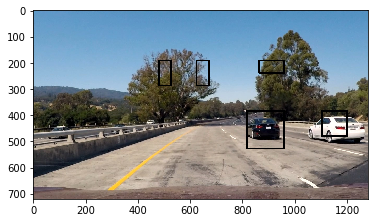

In [8]:
image = mpimg.imread('./test_images/test1.jpg')
image = image.astype(np.float32)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

#window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
#window_img = window_img*255
plt.imshow(draw_img)

In [99]:
left_lane = None
right_lane = None


def find_lanes_pipeline(img):
    global counter
    global gen_images
    global left_lane
    global right_lane
    
    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Wrap image by running a perspective transform
    warped_img = warp_image(img)
    
    #build and apply gradient and color tresholds 
    gradient_img = color_and_gradient_pipeline(warped_img)
    
    # find lanes
    left_fit, right_fit, out_img = find_lanes(gradient_img)

    #apply lanes to a current ones by smoothing
    #the addition lanes = 0.9*lanes + 0.1*new_lanes
    if left_lane is None:
        left_lane = left_fit
        right_lane = right_fit
    else:
        # compute the area for current and newly found lanes
        # if deviation betweein the areas is too big ignore 
        # new lanes, that is likely an indication of some picked
        # artifacts in algorithm
        contour1 = np.concatenate((left_lane.astype(np.float), right_lane.astype(np.float)))
        contour1 = contour1.reshape((-1,1,2)).astype(np.int32)        
        cntArea1 = cv2.contourArea(contour1)
        if left_fit is not None and right_fit is not None:
            contour2 =  np.concatenate((left_fit.astype(np.float), right_fit.astype(np.float)))
            contour2 = contour2.reshape((-1,1,2)).astype(np.int32)        
            cntArea2 = cv2.contourArea(contour2)
            if abs(cntArea2 - cntArea1) < 200000:
                left_lane = 0.9 * left_lane + 0.1 * left_fit
                right_lane = 0.9 * right_lane + 0.1 * right_fit
            
    # draw lanes and return lane curvature and car position off the camera center
    found_lanes_img, curverad, car_offset = draw_lanes(left_lane, right_lane, gradient_img, out_img)
    unwarped_img = unwarp_image(found_lanes_img)

    # Now our radius of curvature is in meters
    cv2.putText(img, curverad, (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(img, car_offset, (40, 140), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    result = cv2.addWeighted(unwarped_img.astype(np.uint8), 0.5, img, 1, 0)
    if gen_images:
        im = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./images/result' + str(counter) + '.png', im)
    counter = counter + 1
    
    return result

In [139]:
#### Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0

def process_image(image):
    return find_lanes_pipeline(image)

output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
videos = glob.glob('./project_video.mp4')

# Step through the list and search for chessboard corners
for video in videos:
    output = 'test_videos_output/' + video
    clip = VideoFileClip(video)
    #.subclip(0,10)
    if not os.path.exists('test_videos_output'):
        os.makedirs('test_videos_output')
    lane_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/./challenge_video.mp4
[MoviePy] Writing video test_videos_output/./challenge_video.mp4



100%|██████████| 485/485 [01:47<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/./challenge_video.mp4 

CPU times: user 1min 59s, sys: 8.76 s, total: 2min 8s
Wall time: 1min 48s
